In [1]:
#Importing Data from the CSV file
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time
from scipy import spatial
from itertools import combinations 
import pickle

28*28 - one row size = 784 - one training data

In [2]:
def input_read(file, sep, class0=None, class1=None):
    myFile = pd.read_csv(file, sep=sep, header=None, index_col=False)
    if ((class0!=None) and (class1!=None)):
        df_train = myFile[(myFile.get(784) == class0) | (myFile.get(784) == class1)]
    else: df_train = myFile
    train_classes = df_train[784]
    if ((class0!=None) and (class1!=None)):
        train_classes = (train_classes.apply(lambda x: 1 if (x==class1) else -1))*1.
    train_classes.index = np.arange(0, len(df_train))
    df_train = df_train.drop(784, axis=1)
    df_train.index=(np.arange(0, len(df_train)))
    df_train /= 255
    return df_train.to_numpy(), train_classes.to_numpy();

In [3]:
def calc_accuracy(classes, pred_classes):   
    acc = 0
    for i in range(len(classes)):
        if (classes[i]==pred_classes[i]):
            acc+=1
    acc = (acc/len(classes))*100
    return acc

In [4]:
def gauss_kernel_cvxopt(X_train, train_classes, c=1):
    sv_pos_ind=[]
    sv_neg_ind=[]
    start =time.time()
    m,n = X_train.shape
    K = np.zeros((m,m))
    gamma = 0.05
    start = time.time()
    pdist = spatial.distance.pdist(X_train, 'sqeuclidean')
    K = np.exp(-1*gamma*spatial.distance.squareform(pdist))
    end = time.time()
    print("Time to Calculate Gaussian Kernel matrix for CVXOPT= {}s".format(end-start))

    P = cvxopt_matrix(np.outer(train_classes, train_classes)*K)
    q = cvxopt_matrix(-1*np.ones((m,1)))
    G1 =-1*np.eye(m)
    G2 =c*np.eye(m)
    G = cvxopt_matrix(np.vstack((G1,G2)))
    h1 = np.zeros(m)
    h2 = np.ones(m)*c
    h = cvxopt_matrix(np.hstack((h1,h2)))
    A = cvxopt_matrix(train_classes.reshape(1,-1)*1.)
    b = cvxopt_matrix(np.zeros(1))
    cvx_solver = cvxopt_solvers.qp(P, q, G, h, A, b)
    print("The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = {}sec".format(time.time()-start))    

    return cvx_solver;

In [5]:
def train_classifiers(X_train, train_classes, class1, class2):
    
    train_classes = train_classes.reshape(-1,1)
    m,n = X_train.shape
    c=1 #penalty weight
    print("Running CVX Optimizer to classify Class {} and Class {} with Gaussian Kernel".format(class1, class2))
    print("--------------------TRAINING--------------------------------------------")
    
    cvx_solver = gauss_kernel_cvxopt(X_train, train_classes, c)
    return cvx_solver

In [6]:
def predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w, b, kernel_shape, supp_vec_ind, alpha):
    if(kernel_shape == 'linear'):
        train_pred = [1.0 if x >=0 else -1. for x in (np.dot(X_train,w) + b) ]
        train_acc = calc_accuracy(train_classes, train_pred)

        val_pred = [1. if x >=0 else -1. for x in (np.dot(X_val,w) + b) ]
        val_acc = calc_accuracy(val_classes, val_pred)

        test_pred = [1. if x >=0 else -1. for x in (np.dot(X_test,w) + b) ]
        test_acc = calc_accuracy(test_classes, test_pred)
        
    elif(kernel_shape == 'gaussian'):
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_train, 'sqeuclidean')
        K_train = np.exp(-1*0.05*(cdist))
        w = np.dot(K_train.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        train_pred = w + b
        
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_val, 'sqeuclidean')
        K_val = np.exp(-1*0.05*(cdist))
        w = np.dot(K_val.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        val_pred = w + b
        
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_test, 'sqeuclidean')
        K_test = np.exp(-1*0.05*(cdist))
        w = np.dot(K_test.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        test_pred = w + b
        
    return train_pred, val_pred, test_pred;

# 50 mins to train classifiers 

In [7]:
label=range(10)
comb = combinations(label, 2) 
num_classifier=0
for i in list(comb): 
    num_classifier+=1
    
comb = combinations(label, 2) 

cvx_solver = []
print(num_classifier)

#Training all the classifiers per class pair
for k in list(comb):   
    X_train, train_classes = input_read('fashion_mnist/train.csv', ',', k[0], k[1])
    cvx_solver.append(train_classifiers(X_train, train_classes, k[0], k[1]))

45
Running CVX Optimizer to classify Class 0 and Class 1 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 5.133698463439941s
     pcost       dcost       gap    pres   dres
 0: -1.6492e+02 -6.6070e+03  3e+04  2e+00  2e-15
 1: -1.1407e+02 -3.0686e+03  5e+03  2e-01  2e-15
 2: -1.0459e+02 -7.6952e+02  9e+02  3e-02  2e-15
 3: -1.2684e+02 -3.0203e+02  2e+02  6e-03  2e-15
 4: -1.4133e+02 -2.0101e+02  6e+01  1e-03  2e-15
 5: -1.4945e+02 -1.6809e+02  2e+01  2e-04  2e-15
 6: -1.5144e+02 -1.6280e+02  1e+01  3e-05  2e-15
 7: -1.5364e+02 -1.5728e+02  4e+00  7e-06  1e-15
 8: -1.5443e+02 -1.5550e+02  1e+00  2e-15  2e-15
 9: -1.5478e+02 -1.5492e+02  1e-01  2e-15  2e-15
10: -1.5483e+02 -1.5484e+02  4e-03  5e-15  2e-15
11: -1.5483e+02 -1.5483e+02  6e-05  2e-15  2e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 80.32979035377502sec
Running CVX Optimizer to

 9: -1.1485e+02 -1.1486e+02  5e-03  9e-09  1e-15
10: -1.1485e+02 -1.1485e+02  1e-04  2e-10  1e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 99.23983669281006sec
Running CVX Optimizer to classify Class 1 and Class 2 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 5.132903575897217s
     pcost       dcost       gap    pres   dres
 0: -1.3552e+02 -7.1330e+03  3e+04  2e+00  1e-15
 1: -8.6508e+01 -3.3924e+03  5e+03  2e-01  2e-15
 2: -7.2456e+01 -7.5584e+02  9e+02  3e-02  2e-15
 3: -9.8211e+01 -2.9087e+02  2e+02  6e-03  2e-15
 4: -1.1260e+02 -1.7965e+02  7e+01  2e-03  2e-15
 5: -1.2011e+02 -1.4295e+02  2e+01  3e-04  1e-15
 6: -1.2381e+02 -1.3099e+02  7e+00  2e-14  1e-15
 7: -1.2520e+02 -1.2765e+02  2e+00  1e-14  1e-15
 8: -1.2579e+02 -1.2645e+02  7e-01  3e-15  1e-15
 9: -1.2601e+02 -1.2606e+02  5e-02  2e-15  1e-15
10: -1.2603e+02 -1.2603e+02

Running CVX Optimizer to classify Class 2 and Class 3 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 4.947459697723389s
     pcost       dcost       gap    pres   dres
 0: -3.0404e+02 -8.2833e+03  4e+04  2e+00  1e-15
 1: -2.1981e+02 -4.4663e+03  7e+03  3e-01  2e-15
 2: -1.8274e+02 -1.0106e+03  1e+03  3e-02  2e-15
 3: -2.3561e+02 -4.7608e+02  3e+02  6e-03  2e-15
 4: -2.6244e+02 -3.3488e+02  8e+01  1e-03  2e-15
 5: -2.7389e+02 -2.9769e+02  2e+01  2e-04  2e-15
 6: -2.7877e+02 -2.8539e+02  7e+00  4e-05  2e-15
 7: -2.8041e+02 -2.8192e+02  2e+00  3e-06  2e-15
 8: -2.8091e+02 -2.8102e+02  1e-01  7e-08  2e-15
 9: -2.8095e+02 -2.8095e+02  2e-03  9e-10  2e-15
10: -2.8095e+02 -2.8095e+02  4e-05  1e-11  2e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 61.66486883163452sec
Running CVX Optimizer to classify Class 2 and Class 4 with Gaussian Kernel
-

12: -1.2186e+02 -1.2186e+02  3e-06  6e-15  1e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 72.04822754859924sec
Running CVX Optimizer to classify Class 3 and Class 6 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 4.936317443847656s
     pcost       dcost       gap    pres   dres
 0: -5.1433e+02 -9.6131e+03  5e+04  3e+00  2e-15
 1: -3.9419e+02 -5.7409e+03  8e+03  3e-01  2e-15
 2: -3.6455e+02 -1.3710e+03  1e+03  2e-02  3e-15
 3: -4.4119e+02 -7.5464e+02  3e+02  5e-03  2e-15
 4: -4.7842e+02 -5.8509e+02  1e+02  5e-04  2e-15
 5: -4.9392e+02 -5.2894e+02  4e+01  1e-04  2e-15
 6: -4.9931e+02 -5.1319e+02  1e+01  3e-05  2e-15
 7: -5.0143e+02 -5.0716e+02  6e+00  1e-13  2e-15
 8: -5.0278e+02 -5.0408e+02  1e+00  4e-15  2e-15
 9: -5.0315e+02 -5.0328e+02  1e-01  3e-14  2e-15
10: -5.0319e+02 -5.0320e+02  4e-03  3e-14  2e-15
11: -5.0319e+02 -5.0319e+02

 4: -8.8826e+01 -1.2601e+02  4e+01  7e-04  1e-15
 5: -9.4967e+01 -1.0838e+02  1e+01  2e-04  1e-15
 6: -9.7972e+01 -1.0158e+02  4e+00  2e-05  1e-15
 7: -9.8948e+01 -9.9746e+01  8e-01  2e-06  1e-15
 8: -9.9202e+01 -9.9319e+01  1e-01  2e-07  1e-15
 9: -9.9246e+01 -9.9249e+01  3e-03  3e-09  1e-15
10: -9.9248e+01 -9.9248e+01  7e-05  7e-11  1e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 61.85584998130798sec
Running CVX Optimizer to classify Class 5 and Class 6 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 4.910359621047974s
     pcost       dcost       gap    pres   dres
 0: -2.0533e+02 -7.5506e+03  3e+04  2e+00  1e-15
 1: -1.2813e+02 -3.9857e+03  6e+03  2e-01  2e-15
 2: -9.5987e+01 -7.8644e+02  8e+02  2e-02  2e-15
 3: -1.4760e+02 -3.3431e+02  2e+02  5e-03  2e-15
 4: -1.6699e+02 -2.3327e+02  7e+01  1e-03  1e-15
 5: -1.7565e+02 -2.0037e+02

Time to Calculate Gaussian Kernel matrix for CVXOPT= 4.935797452926636s
     pcost       dcost       gap    pres   dres
 0: -3.8746e+02 -9.5957e+03  5e+04  3e+00  3e-15
 1: -2.8432e+02 -5.5742e+03  9e+03  3e-01  3e-15
 2: -2.5152e+02 -1.4261e+03  1e+03  3e-02  3e-15
 3: -3.0818e+02 -7.0514e+02  4e+02  9e-03  3e-15
 4: -3.4189e+02 -4.9364e+02  2e+02  2e-03  3e-15
 5: -3.5935e+02 -4.1679e+02  6e+01  4e-04  3e-15
 6: -3.6813e+02 -3.8647e+02  2e+01  6e-15  3e-15
 7: -3.7153e+02 -3.7782e+02  6e+00  2e-14  3e-15
 8: -3.7293e+02 -3.7451e+02  2e+00  2e-14  3e-15
 9: -3.7345e+02 -3.7358e+02  1e-01  4e-14  3e-15
10: -3.7350e+02 -3.7350e+02  4e-03  5e-14  3e-15
11: -3.7350e+02 -3.7350e+02  8e-05  1e-14  3e-15
Optimal solution found.
The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = 66.94181180000305sec
Running CVX Optimizer to classify Class 8 and Class 9 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian 

In [ ]:
import pickle
with open('fashion_MNIST_SVM.pickle','wb') as f:
    pickle.dump(cvx_solver, f)

In [11]:
cvx_solver = pickle.load(open("fashion_MNIST_SVM.pickle", "rb"))


In [8]:
X_val, val_classes = input_read('fashion_mnist/val.csv', ',')
X_test, test_classes = input_read('fashion_mnist/test.csv', ',')

In [9]:
classifiers = list(combinations(label, 2) )
#train_label_score = np.zeros((len(X_train), len(label)))
val_label_score = np.zeros((len(X_val), len(label)))
test_label_score = np.zeros((len(X_test), len(label)))

start = time.time()
for i in range(len(classifiers)):
    k = classifiers[i] # Stores class pair for the current classifier
    X_train, train_classes = input_read('fashion_mnist/train.csv', ',', k[0], k[1])
    #print(k[0], k[1])
    train_classes = train_classes.reshape(-1,1)
    alpha = np.array(cvx_solver[i]['x'])
    S = (alpha > 1e-3)
    supp_vec_ind = np.where(S == True)[0]
    S = S.flatten()
    pdist = spatial.distance.pdist(X_train[supp_vec_ind], 'sqeuclidean')
    K_train = np.exp(-1*0.05*spatial.distance.squareform(pdist))
    w_train = np.dot(K_train.T, (alpha[S]*train_classes[S]))
    bias = train_classes[S] - w_train
    b = np.mean(bias)
    train_pred, val_pred, test_pred= predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w_train, b, 'gaussian', supp_vec_ind, alpha)    
    #train_pred = [k[1] if x >=0 else k[0] for x in train_pred ]
    
    class1=np.where(val_pred >=0)[0]
    class0=np.where(val_pred <0)[0]
    val_pred[class1] = 1/(1 + np.exp(-np.abs(val_pred[class1])))
    val_pred[class0] = 1/(1 + np.exp(-np.abs(val_pred[class0])))
    val_label_score[class1,k[1]]+=val_pred[class1,0]
    val_label_score[class0,k[0]]+=val_pred[class0,0]
    
    class1=np.where(test_pred >=0)[0]
    class0=np.where(test_pred <0)[0]
    test_pred[class1] = 1/(1 + np.exp(-np.abs(test_pred[class1])))
    test_pred[class0] = 1/(1 + np.exp(-np.abs(test_pred[class0])))
    test_label_score[class1,k[1]]+=test_pred[class1,0]
    test_label_score[class0,k[0]]+=test_pred[class0,0]

print("The time taken to predict the scores is {}sec".format(time.time()-start))

NameError: name 'label' is not defined

In [14]:
val_label_pred = [np.where(x == max(x))[0][0] for x in val_label_score[:,:]]
test_label_pred  = [np.where(x == max(x))[0][0] for x in test_label_score[:,:]]
val_acc = calc_accuracy(val_classes, val_label_pred)
test_acc = calc_accuracy(test_classes, test_label_pred)
#print(val_acc, test_acc)

[supp_vec_ind]#Implementation using SVM Classifier

In [15]:
print("\n-----------GAUSSIAN KERNEL(Multi-class)----------------")
print("---------------CVXOPT------------------------------------")

print("The Validation accuracy of the model with 10C2 classifiers is= {:2.3f}%".format(val_acc))
print("The test accuracy of the model with 10C2 classifiers is = {:2.3f}%".format(test_acc))


-----------GAUSSIAN KERNEL(Multi-class)----------------
---------------CVXOPT------------------------------------
The Validation accuracy of the model with 10C2 classifiers is= 87.600%
The test accuracy of the model with 10C2 classifiers is = 87.800%


# Read whole input training set for SVM classifier

In [10]:
X_train, train_classes = input_read('fashion_mnist/train.csv', ',')


In [11]:
def sklearn_svm(X_train, train_classes, shape, gamma='scale'):
    start = time.time()
    svc_classifier = svc(kernel=shape, gamma=gamma, decision_function_shape='ovo', probability=True)
    svc_classifier.fit(X_train, train_classes)
    train_pred_svc = svc_classifier.predict_proba(X_train)
    val_pred_svc = svc_classifier.predict_proba(X_val)
    test_pred_svc = svc_classifier.predict_proba(X_test)
    train_acc_svc = svc_classifier.score(X_train, train_classes)
    val_acc_svc = svc_classifier.score(X_val, val_classes)
    test_acc_svc = svc_classifier.score(X_test, test_classes)
    print("The time taken to train SVM model using SVM classifier SKLEARN and {} Kernel = {}sec"
          .format(shape, time.time()-start))    
    print("The number of support vectors in SVM classifier trained model with {} kernel = {}"
          .format(shape, svc_classifier.n_support_))
    return train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc;

In [12]:
print("Running SVM Classifier from SKLEARN to classify with Gaussian Kernel")
print("--------------------TRAINING--------------------------------------------")
train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc= sklearn_svm(X_train, train_classes, 'rbf', 0.05)

val_label_pred_svc = [np.where(x == max(x))[0][0] for x in val_pred_svc[:,:]]
test_label_pred_svc  = [np.where(x == max(x))[0][0] for x in test_pred_svc[:,:]]
val_acc = calc_accuracy(val_classes, val_label_pred_svc)
test_acc = calc_accuracy(test_classes, test_label_pred_svc)

print("-----------SVM classifier--------------")

#print("The number of support vectors are = {}".format())
print("The training accuracy of the SVM model is = {:2.3f}%".format(train_acc_svc*100))
print("The Validation accuracy of the SVM model is= {:2.3f}%".format(val_acc))
print("The test accuracy of the SVM model is = {:2.3f}%".format(test_acc))

Running SVM Classifier from SKLEARN to classify with Gaussian Kernel
--------------------TRAINING--------------------------------------------
The time taken to train SVM model using SVM classifier SKLEARN and rbf Kernel = 1715.192069530487sec
The number of support vectors in SVM classifier trained model with rbf kernel = [1291  368 1543 1144 1541 1282 1832  770 1078  816]
-----------SVM classifier--------------
The training accuracy of the SVM model is = 96.920%
The Validation accuracy of the SVM model is= 88.160%
The test accuracy of the SVM model is = 88.120%


In [13]:
def plot_conf_matrix(kernel_shape, test_classes, test_pred, test_pred_svc ):
    print("\nPlotting Confusion Matrix for {} Kernel - CVXOPT vs. SVMC-library".format(kernel_shape))

    conf_matrix_cvxopt = confusion_matrix(test_classes, test_pred)
    conf_matrix_svmC = confusion_matrix(test_classes, test_pred_svc)
    fig = plt.figure(1)
    ax= fig.add_subplot(111)
    sns.heatmap(conf_matrix_cvxopt, annot=True, ax = ax, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
    #ax.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
    ax.set_ylabel('Actual labels');
    ax.set_xlabel('Predicted labels'); 
    ax.set_title('Confusion Matrix with CVX '); 
    #ax.xaxis.set_ticklabels(['y=0', 'y=1']); ax.yaxis.set_ticklabels(['y=0', 'y=1']);
    #fig.savefig('cm_cvxopt_multiclass.png', dpi=1000, bbox_inches='tight')

    fig1 = plt.figure(2)
    ax1 = fig1.add_subplot(111)
    sns.heatmap(conf_matrix_svmC, annot=True, ax = ax1, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
    #ax1.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
    ax1.set_ylabel('Actual labels');
    ax1.set_xlabel('Predicted labels'); 
    ax1.set_title('Confusion Matrix with SVM-C'); 
    #ax1.xaxis.set_ticklabels(['y=0', 'y=1']); ax1.yaxis.set_ticklabels(['y=0', 'y=1']);

    fig.tight_layout(pad=3.0)
    #fig1.savefig('cm_svm_multiclass.png', dpi=1000, bbox_inches='tight')
    
    plt.show()

In [14]:
plot_conf_matrix('gaussian', val_classes, val_label_pred, val_label_pred_svc)

NameError: name 'val_label_pred' is not defined


Plotting Confusion Matrix for gaussian Kernel - CVXOPT vs. SVMC-library


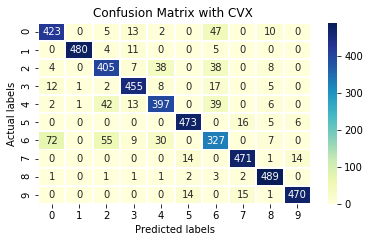

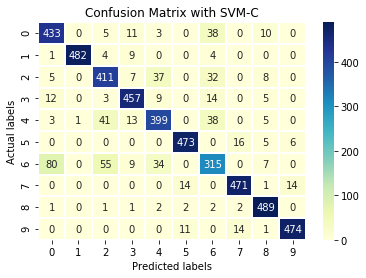

In [38]:
plot_conf_matrix('gaussian', test_classes, test_label_pred, test_label_pred_svc)